# **Install required libraries**

In [49]:
# %pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community langchain-groq langchain-openai sentence-transformers langchain_huggingface --upgrade --force-reinstall

# **Import necessary packages and modules**

In [50]:
from langchain_openai import ChatOpenAI
import os
from crewai_tools import PDFSearchTool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import Chroma
from crewai_tools  import tool
from crewai import Crew
from crewai import Task
from crewai import Agent

# **Set up GROQ API Key and the LLM model using Groq's Llama3**

In [51]:
import os

GROQ_API_KEY = input("Enter your GROQ API Key: ")
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
llm = ChatOpenAI(
    openai_api_base="https://api.groq.com/openai/v1",
    api_key=os.getenv("GROQ_API_KEY"),
    model_name="llama-3.1-8b-instant",
    temperature=0.1,
    max_tokens=1000,
)

# **Define the PDF-based RAG tool with LLM and embedding model**

In [52]:
rag_tool = PDFSearchTool(
    pdf='crew_data/doc.pdf',
    name="vectorstore_search",
    config=dict(
        llm=dict(
            provider="groq", # or google, openai, anthropic, llama2, ...
            config=dict(
                model="llama-3.1-8b-instant",
                api_key=os.getenv("GROQ_API_KEY"),
                # temperature=0.5,
                # top_p=1,
                # stream=true,
            ),
        ),
        embedder=dict(
            provider="huggingface", # or openai, ollama, ...
            config=dict(
                model="BAAI/bge-small-en-v1.5",
                #task_type="retrieval_document",
                # title="Embeddings",
            ),
        ),
    )
)

# **Query the RAG tool to perform document-based search**

In [53]:
rag_tool.run("What does Sporo Health do?")

Using Tool: vectorstore_search


'Relevant Content:\nincreasing capabilities and token storage of LLMs in 2024 such as Google’s Med-Gemini, Meta’s Llama 3, OpenAI’s ChatGPT4, or Anthropic’s Claude 3.5, has allowed for these models to process the enormous portions of information for summarization and analysis. In recognition of the stringent accuracy, the need for personalization, privacy regulations, and the high knowledge floor needed for AI in clinical workflow, the innovation space gave birth to companies like Sporo Health to combat the aforementioned issues in clinical summarization using AI agents. Several case studies verify AI usage in various clinical settings to aid in chart review and summarization of clinical information. 3\n\nASSESSING THE ROLE OF CLINICAL SUMMARIZATION AND PATIENT CHART REVIEW WITHIN COMMUNICATIONS , MEDICAL MANAGEMENT ,AND DIAGNOSTICS Chanseo Lee Yale School of Medicine and Sporo Health New Haven, CT 06510 chanseo.lee@yale.eduKimon-Aristotelis Vogt Sporo Health Boston, MA 02134 kvogt@spo

# **Use .similarity_search() to see what documents match a query**

In [54]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings

# 1. Load PDF
loader = PyPDFLoader("crew_data/doc.pdf")
docs = loader.load()

# 2. Chunk text
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
chunks = splitter.split_documents(docs)

# 3. Embeddings
embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

# 4. Build vectorstore
vectorstore = Chroma.from_documents(chunks, embedder)

# 5. Now use similarity_search()
results = vectorstore.similarity_search("What does Sporo Health do?", k=4)

for r in results:
    print(r.page_content)

used to determine illnesses or patient information from clinical free-text.[19]The increasing capabilities and token
storage of LLMs in 2024 such as Google’s Med-Gemini, Meta’s Llama 3, OpenAI’s ChatGPT4, or Anthropic’s Claude
3.5, has allowed for these models to process the enormous portions of information for summarization and analysis.
In recognition of the stringent accuracy, the need for personalization, privacy regulations, and the high knowledge
floor needed for AI in clinical workflow, the innovation space gave birth to companies like Sporo Health to combat
the aforementioned issues in clinical summarization using AI agents. Several case studies verify AI usage in various
clinical settings to aid in chart review and summarization of clinical information.
3
used to determine illnesses or patient information from clinical free-text.[19]The increasing capabilities and token
storage of LLMs in 2024 such as Google’s Med-Gemini, Meta’s Llama 3, OpenAI’s ChatGPT4, or Anthropic’s Claud

# **Visualize embeddings using PCA**

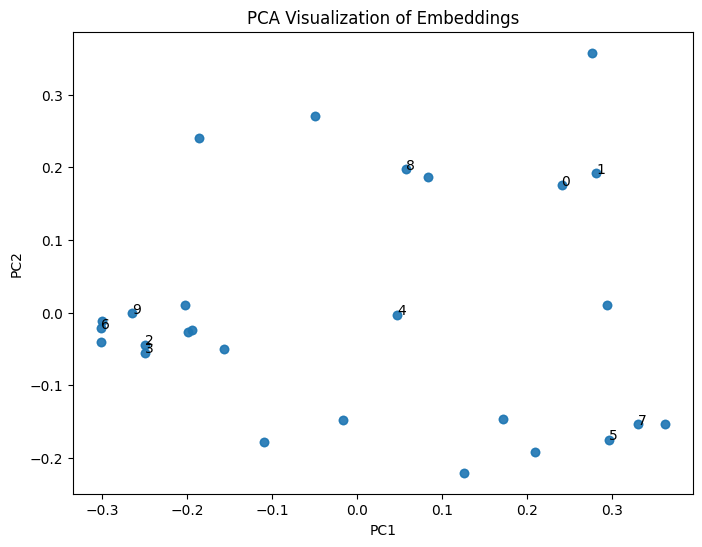

In [55]:
embeddings = vectorstore._collection.get(include=["embeddings"])["embeddings"]
docs = vectorstore._collection.get()["documents"]

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# embeddings: a list or array of vectors (n_samples x embedding_dim)
# labels: optional — for coloring points (e.g., chunk index or topic)

pca = PCA(n_components=2)
emb_2d = pca.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.7)

# optional: label first few points
for i in range(min(10, len(emb_2d))):
    plt.text(emb_2d[i,0], emb_2d[i,1], str(i))

plt.title("PCA Visualization of Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# **Visualize embeddings using t-SNE**

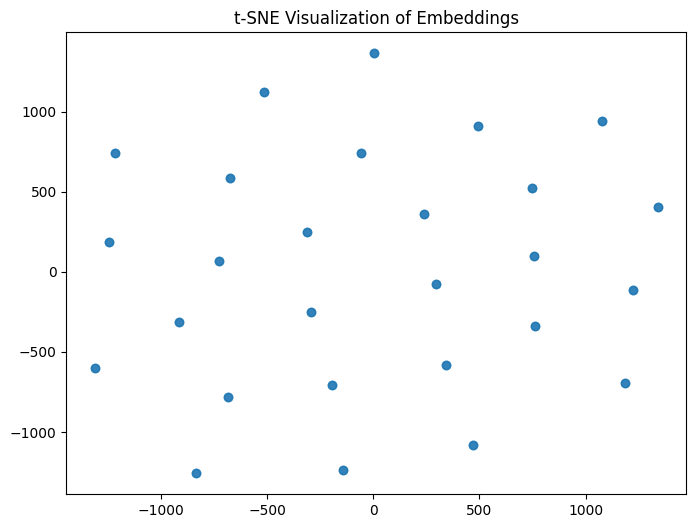

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Convert list → numpy array
embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, perplexity=26, learning_rate=200, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], alpha=0.7)

plt.title("t-SNE Visualization of Embeddings")
plt.show()

# **Rebuild the FAISS index**

In [57]:
# !pip install faiss-cpu

from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
import os, glob

# 1) Load embedding model
embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

# 2) Load all docs from a folder
def load_texts(path="crew_data"):
    texts = []
    for file in glob.glob(f"{path}/**/*.*", recursive=True):
        if file.endswith((".txt", ".md", ".pdf")):
            with open(file, "r", errors="ignore") as f:
                texts.append(f.read())
    return texts

raw_docs = load_texts("crew_data")

# 3) Split into chunks
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=200)
docs = splitter.create_documents(raw_docs)

# 4) Build FAISS index
faiss_store = FAISS.from_documents(docs, embedder)

# 5) Save FAISS index
faiss_store.save_local("faiss_index")

# **Reload the saved FAISS Index and test retrieval with new queries**

In [58]:
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# 1) Load embedding model
embedder = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

# 1) Reload FAISS index
faiss_store = FAISS.load_local(
    folder_path="faiss_index",
    embeddings=embedder,
    allow_dangerous_deserialization=True
)

# Test Retrieval With Queries
query = "How does Sporo handle patient chart reviews?"
results = faiss_store.similarity_search(query, k=5)

for i, r in enumerate(results):
    print(f"\nResult {i+1}:")
    print(r.page_content[:500])


Result 1:
endobj
6 0 obj
<< /D (section.2) /S /GoTo >>
endobj
7 0 obj
<< /D [ 53 0 R /XYZ 72 720 null ] >>
endobj
8 0 obj
<< /A 6 0 R /Next 12 0 R /Parent 125 0 R /Prev 4 0 R /Title 9 0 R >>
endobj
9 0 obj
( Q u a n t i f y i n g   P a t i e n t   C h a r t   R e v i e w  s   I m p a c t   o n   D i a g n o s t i c   A c c u r a c y   a n d   T i m e   B u r d e n)
endobj
10 0 obj
<< /D (section.3) /S /GoTo >>
endobj
11 0 obj
<< /D [ 53 0 R /XYZ 72 412.824 null ] >>
endobj
12 0 obj
<< /A 10 0 R /Next 16 

Result 2:
22 0 obj
<< /D (section.6) /S /GoTo >>
endobj
23 0 obj
<< /D [ 66 0 R /XYZ 72 720 null ] >>
endobj
24 0 obj
<< /A 22 0 R /Next 28 0 R /Parent 125 0 R /Prev 20 0 R /Title 25 0 R >>
endobj
25 0 obj
( R a d i o l o g y   C a s e   R e p o r t s   a n d   B i o m e d i c a l   R e s e a r c h)
endobj
26 0 obj
<< /D (section.7) /S /GoTo >>
endobj
27 0 obj
<< /D [ 66 0 R /XYZ 72 469.549 null ] >>
endobj
28 0 obj
<< /A 26 0 R /Next 32 0 R /Parent 125 0 R /Prev 24 0 R /Title 29 0 

# **Set up Tavily API Key and run a web search using the Tavily tool**

In [59]:
import os
TAVILY_API_KEY = input("Enter your Tavily API Key: ")
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

web_search_tool = TavilySearchResults(k=3, tavily_api_key=os.getenv("TAVILY_API_KEY"), name="web_search")

web_search_tool.run("What does Sporo Health do?")

[{'url': 'https://sporohealth.com/',
  'content': 'Experiment with AI in healthcare just became easy with Sporo Health’s proprietary medical AI Agents. Integrating AI in your healthcare organizations just became easy with Sporo Health’s proprietary medical AI agents. #### Sporo’s AI Scribe. Sporo efficiently analyzes large patient databases, offering quick summaries and comprehensive analytics to support researchers in data-intensive studies, enhancing productivity. Sporo serves as an educational resource for healthcare students, facilitating learning in patient presentation and management through practical, tech-driven insights. I have been a family physician for two decades and Sporo Health is a breakthrough in AI scribing technology. Our proprietary medical LLMs, unique architecture, and private instances for each user deliver unparalleled accuracy and customization for healthcare-specific needs, ensuring secure and efficient AI-driven solutions. Sporo Health’s solutions are availab

# **Define Router AI agent with its role and toolset**

In [98]:
@tool
def router_tool(question):
  """Router Function"""
  if 'Sporo Health' in question:
    return 'vectorstore'
  else:
    return 'web_search'

Router_Agent = Agent(
    role="Router",
    goal="Return exactly one word: 'vectorstore' or 'websearch'.",
    backstory=(
        "Your job is to decide which retrieval source should answer the user's question.\n"
        "- If the question is about Sporo Health, its workflows, services, features, "
        "clinical processes, or anything likely contained in the Sporo PDFs → respond: vectorstore.\n"
        "- If the question requires external/general knowledge or anything unlikely in the PDFs → respond: websearch.\n\n"
        "You MUST output ONLY one word: vectorstore or websearch.\n"
        "Do NOT provide explanations.\n"
        "Do NOT call any tools.\n"
        "Do NOT think step-by-step.\n"
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

# **Define Retriever AI agent with its role and toolset**

In [99]:
Retriever_Agent = Agent(
    role="Retriever",
    goal="Retrieve factual information using the correct tool and answer concisely.",
    backstory=(
        "You retrieve information using the tool selected by the router. "
        "You NEVER invent tool outputs. "
        "You answer ONLY using the actual text returned by the tool."
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

# **Define Grader AI agent with its role and toolset**

In [100]:
Grader_agent = Agent(
    role='Grader',
    goal='Determine whether the retriever answer is relevant to the user question.',
    backstory=(
        "You evaluate ONLY relevance. You do NOT repeat or quote content. "
        "You do NOT explain your reasoning. You return only 'yes' or 'no'."
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

# **Define Hallucination AI agent with its role and toolset**

In [101]:
hallucination_grader = Agent(
    role="Hallucination Grader",
    goal="Return ONLY 'yes' or 'no' based on whether the retriever answer is factually grounded.",
    backstory=(
        "You do NOT answer the user question. "
        "You ONLY judge whether the retriever's answer is consistent with retrieved facts. "
        "You NEVER generate new facts. You NEVER add commentary. "
        "You ALWAYS output exactly one word: yes or no."
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

# **Define the task Router agent is responsible for**

In [102]:
router_task = Task(
    description=(
        "Analyze the question:\n"
        "{question}\n\n"
        "If it relates to Sporo Health (services, workflows, charting, clinical processes, "
        "or information likely stored in Sporo PDFs), return exactly:\n"
        "vectorstore\n\n"
        "Otherwise return exactly:\n"
        "websearch\n\n"
        "Return ONLY one word. Do NOT add explanations. Do NOT call tools."
    ),
    expected_output="Exactly one word: vectorstore or websearch.",
    agent=Router_Agent,
)

# **Define the task Retriever agent is responsible for**

In [103]:
retriever_task = Task(
    description=(
        "You are a retrieval-only agent.\n\n"

        "Question:\n"
        "{question}\n\n"

        "Router output (from context):\n"
        "- EXACTLY one word: 'vectorstore' or 'websearch'.\n\n"

        "INSTRUCTIONS:\n"
        "- Read the router output from your context.\n"
        "- If router output is 'vectorstore':\n"
        "    Call rag_tool with: {{\"query\": \"{question}\"}}\n"
        "- If router output is 'websearch':\n"
        "    Call web_search_tool with: {{\"query\": \"{question}\"}}\n\n"

        "STRICT RULES:\n"
        "- You MUST call exactly ONE tool.\n"
        "- You MUST NOT invent, summarize, explain, or interpret results.\n"
        "- You MUST NOT answer the question.\n"
        "- You MUST NOT add conclusions or opinions.\n\n"

        "OUTPUT RULES (ABSOLUTE):\n"
        "- Output ONLY the raw text returned by the tool.\n"
        "- Do NOT add headings, prefixes, or commentary.\n"
        "- Do NOT write a final answer.\n"
    ),
    expected_output="Raw retrieved text only.",
    agent=Retriever_Agent,
    context=[router_task],
    tools=[rag_tool, web_search_tool],
)

# **Define the task Grader agent is responsible for**

In [104]:
grader_task = Task(
    description=(
        "You are a strict binary evaluator.\n\n"

        "Question:\n"
        "{question}\n\n"

        "TASK:\n"
        "- Determine whether the retrieved text contains information that could plausibly answer the question.\n\n"

        "ABSOLUTE OUTPUT RULES:\n"
        "- Output EXACTLY one word: yes or no.\n"
        "- Use lowercase only.\n"
        "- No punctuation.\n"
        "- No explanations.\n"
        "- No additional text.\n"
        "- Do NOT answer the question.\n"
        "- Do NOT summarize the retrieved text.\n"
    ),
    expected_output="yes or no",
    agent=Grader_agent,
    context=[retriever_task],
    tools=[],
)

# **Define the task Hallucination agent is responsible for**

In [105]:
hallucination_task = Task(
    description=(
        "You are NOT allowed to answer the question.\n"
        "You are ONLY evaluating whether the RETRIEVER'S ANSWER is grounded in real retrieved facts.\n\n"

        "Question:\n{question}\n\n"

        "Your evaluation:\n"
        "- Respond 'yes' if the answer is plausible AND could reasonably come from the retrieved facts.\n"
        "- Respond 'no' if the answer contains fabricated details, speculation, or anything unsupported.\n\n"

        "STRICT RULES:\n"
        "- You MUST output exactly one word: yes or no.\n"
        "- You MUST NOT answer the question.\n"
        "- You MUST NOT rewrite or quote the retriever answer.\n"
        "- You MUST NOT provide reasoning.\n"
        "- You MUST NOT add explanations.\n"
        "- You MUST NOT output anything except 'yes' or 'no'.\n"
        "- If you are uncertain, output 'no'."
    ),
    expected_output="Exactly one word: yes or no.",
    agent=hallucination_grader,
    context=[retriever_task],
)

# **Assemble agents into a Crew to collaborate on the task**

In [106]:
rag_crew = Crew(
    agents=[
        Router_Agent,
        Retriever_Agent,
        Grader_agent,
        hallucination_grader,
    ],
    tasks=[
        router_task,
        retriever_task,
        grader_task,
        hallucination_task,
    ],
    verbose=True,
    process="sequential",
)

# **Start the collaborative process among the agents**

In [107]:
inputs ={"question":"Does Sporo Streamline patient chart reviews?"}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyze the question:
Does Sporo Streamline patient chart reviews?

If it relates to Sporo Health (services, workflows, charting, clinical processes, or information likely stored in Sporo PDFs), return exactly:
vectorstore

Otherwise return exactly:
websearch

Return ONLY one word. Do NOT add explanations. Do NOT call tools.


> Entering new CrewAgentExecutor chain...
Final Answer: vectorstore

> Finished chain.
 [DEBUG]: == [Router] Task output: vectorstore


 [DEBUG]: == Working Agent: Retriever
 [INFO]: == Starting Task: You are a retrieval-only agent.

Question:
Does Sporo Streamline patient chart reviews?

Router output (from context):
- EXACTLY one word: 'vectorstore' or 'websearch'.

INSTRUCTIONS:
- Read the router output from your context.
- If router output is 'vectorstore':
    Call rag_tool with: {"query": "Does Sporo Streamline patient chart reviews?"}
- If router output is 'websearch':
    Call web_search_tool w

# **Store Retriever and Hallucination result in a variable**

In [108]:
import re

match_re = re.search(r"raw_output\s*=\s*'([\s\S]*?)'", str(retriever_task.output))
match_ha = re.search(r"raw_output\s*=\s*'([\s\S]*?)'", str(hallucination_task.output))

retriever_answer = match_re.group(1) if match_re else None
hallucination_result = match_ha.group(1) if match_ha else None

print(retriever_answer)
print(hallucination_result)

Relevant Content:\nASSESSING THE ROLE OF CLINICAL SUMMARIZATION AND PATIENT CHART REVIEW WITHIN COMMUNICATIONS , MEDICAL MANAGEMENT ,AND DIAGNOSTICS Chanseo Lee Yale School of Medicine and Sporo Health New Haven, CT 06510 chanseo.lee@yale.eduKimon-Aristotelis Vogt Sporo Health Boston, MA 02134 kvogt@sporohealth.comSonu Kumar Sporo Health Boston, MA 02134 sonu@sporohealth.com July 25, 2024 ABSTRACT Effective summarization of unstructured patient data in electronic health records (EHRs) is crucial for accurate diagnosis and efficient patient care, yet clinicians often struggle with information overload and time constraints. This review dives into recent literature and case studies on both the significant impacts and outstanding issues of patient chart review on communications, diagnostics, and management. It also discusses recent efforts to integrate artificial intelligence (AI) into clinical summarization tasks, and its transformative impact on the clinician’s potential, including but n

# **Define Answer grader AI agent with its role and toolset**

In [109]:
answer_grader = Agent(
    role="Answer Grader",
    goal="Return a final answer ONLY using allowed sources. NEVER invent content.",
    backstory=(
        "If the hallucination result is 'yes', you ONLY rewrite the retriever's answer "
        "into a clearer, shorter version. "
        "If the hallucination result is 'no', you MUST perform a web search tool call "
        "and use ONLY the returned content to answer. "
        "You are forbidden from adding any new ideas or external knowledge."
    ),
    verbose=True,
    allow_delegation=False,
    llm=llm,
)

# **Define the task Answer grader agent is responsible for**

In [110]:
rewrite_answer_task = Task(
    description=(
        "You will generate the FINAL ANSWER by rewriting the retriever answer.\n\n"

        "Retriever answer:\n{retriever}\n\n"

        "RULES:\n"
        "- Rewrite ONLY the retriever answer.\n"
        "- Do NOT add, remove, or infer any facts.\n"
        "- Do NOT use external knowledge.\n"
        "- Do NOT answer the question.\n"
        "- Do NOT call any tools.\n\n"

        "STRICT OUTPUT RULES:\n"
        "- 2–3 sentences only.\n"
        "- Preserve original meaning exactly.\n"
        "- Output ONLY the rewritten answer.\n"
    ),
    expected_output="A faithful rewrite of the retriever answer.",
    agent=answer_grader,
    tools=[],
)

web_answer_task = Task(
    description=(
        "You will generate the FINAL ANSWER using ONLY the web search results.\n\n"

        "Question:\n{question}\n\n"

        "RULES:\n"
        "- Use ONLY information from the web search tool output.\n"
        "- Do NOT add external knowledge.\n"
        "- Do NOT invent claims.\n"
        "- Do NOT reference retriever output.\n\n"

        "STRICT OUTPUT RULES:\n"
        "- 2–3 sentences only.\n"
        "- Output ONLY the final answer.\n"
    ),
    expected_output="A factual answer based only on web search results.",
    agent=answer_grader,
    tools=[web_search_tool],
)

if hallucination_result == "yes":
    final_task = rewrite_answer_task

else:  # hallucination == "no"
    final_task = web_answer_task

# **Assemble all agents into a Crew to collaborate on the task**

In [111]:
rag_crew = Crew(
    agents=[
        Router_Agent,
        Retriever_Agent,
        Grader_agent,
        hallucination_grader,
        answer_grader,
    ],
    tasks=[
        router_task,
        retriever_task,
        grader_task,
        hallucination_task,
        final_task,
    ],
    verbose=True,
    process="sequential",
)

# **Start the collaborative process among the agents**

In [112]:
inputs ={"question":"Does Sporo Streamline patient chart reviews?","hallucination":hallucination_result,"retriever":retriever_answer}
result = rag_crew.kickoff(inputs=inputs)

 [DEBUG]: == Working Agent: Router
 [INFO]: == Starting Task: Analyze the question:
Does Sporo Streamline patient chart reviews?

If it relates to Sporo Health (services, workflows, charting, clinical processes, or information likely stored in Sporo PDFs), return exactly:
vectorstore

Otherwise return exactly:
websearch

Return ONLY one word. Do NOT add explanations. Do NOT call tools.


> Entering new CrewAgentExecutor chain...
Final Answer: vectorstore

> Finished chain.
 [DEBUG]: == [Router] Task output: vectorstore


 [DEBUG]: == Working Agent: Retriever
 [INFO]: == Starting Task: You are a retrieval-only agent.

Question:
Does Sporo Streamline patient chart reviews?

Router output (from context):
- EXACTLY one word: 'vectorstore' or 'websearch'.

INSTRUCTIONS:
- Read the router output from your context.
- If router output is 'vectorstore':
    Call rag_tool with: {"query": "Does Sporo Streamline patient chart reviews?"}
- If router output is 'websearch':
    Call web_search_tool w

# **Print final result**

In [113]:
print(result)

Effective summarization of unstructured patient data in electronic health records (EHRs) is crucial for accurate diagnosis and efficient patient care, yet clinicians often struggle with information overload and time constraints. This review dives into recent literature and case studies on both the significant impacts and outstanding issues of patient chart review on communications, diagnostics, and management. It also discusses recent efforts to integrate artificial intelligence (AI) into clinical summarization tasks, and its transformative impact on the clinician’s potential.


# **Define Trend analyst AI agent with its role and toolset**

In [114]:
trend_analyst = Agent(
    role="Trend Analyst",
    goal="Summarize the latest news on AI in easy-to-understand language.",
    backstory=(
        "You are an expert in tracking daily shifts in the AI industry. "
        "You monitor emerging technologies, corporate announcements, "
        "research breakthroughs, and major international developments."
    ),
    tools=[web_search_tool],
    llm=llm,
    verbose=True,
    allow_delegation=False,
    max_iter=2
)

# **Define the task Trend analyst agent is responsible for**

In [115]:
ai_news_task = Task(
    description=(
        "Search the web and provide a concise summary of the newest AI news. "
        "Highlight the most impactful updates and trends."
    ),
    agent=trend_analyst,
    expected_output="A 3–6 sentence summary covering the latest AI developments."
)

# **Define Report generator AI agent with its role and toolset**

In [116]:
report_generator = Agent(
    role="Report Generator",
    goal=(
        "Collect insights from other agents and transform them into a clean, "
        "Create concise and structured reports. Never exceed 400 total words "
        "regardless of input length."
        "structured report in Markdown or PDF-ready text."
    ),
    backstory=(
        "You specialize in short, executive-level summaries."
        "You are an expert technical writer. "
        "You create reports that are clear, structured, and visually professional."
    ),
    llm=llm,
    verbose=True,
    allow_delegation=False,
    max_iter=3
)

# **Define the task Report generator agent is responsible for**

In [117]:
generate_report_task = Task(
    description=(
        "Generate a structured Markdown report STRICTLY under 250 words.\n\n"
        "You MUST follow this exact structure:\n\n"
        "## Executive Summary\n"
        "- 2 sentences MAX.\n\n"
        "## Key Insights\n"
        "- Exactly 3–5 bullet points.\n\n"
        "## Trends & Predictions\n"
        "- 2–3 bullet points.\n\n"
        "## Recommended Actions\n"
        "- 2–3 bullet points.\n\n"

        "HARD RULES:\n"
        "- Do NOT exceed 250 words.\n"
        "- Do NOT include sources.\n"
        "- Do NOT add extra sections.\n"
        "- Do NOT delegate work.\n"
    ),
    agent=report_generator,
    expected_output="Markdown strictly under 250 words.",
    context=[ai_news_task]
)

# **Assemble Trend analyst and Report generator agents into a Crew to collaborate on the task**

In [118]:
crew = Crew(
    agents=[trend_analyst, report_generator],
    tasks=[ai_news_task, generate_report_task],
    verbose=True
)

result_markdown = crew.kickoff()
print(result_markdown)

 [DEBUG]: == Working Agent: Trend Analyst
 [INFO]: == Starting Task: Search the web and provide a concise summary of the newest AI news. Highlight the most impactful updates and trends.


> Entering new CrewAgentExecutor chain...
Thought: I now know the final answer

Final Answer: 

As of my knowledge cutoff in December 2023, the AI industry has witnessed significant advancements and updates. Some of the most impactful developments include:

Google's AI-powered chatbot, Bard, was released in competition with Microsoft's Bing AI. This marks a new era in conversational AI, with both companies vying for market share and user adoption.

The European Union has proposed the AI Act, a comprehensive regulatory framework aimed at ensuring the safe and responsible development of AI systems. This legislation has the potential to shape the global AI landscape and influence the way companies design and deploy AI technologies.

The use of AI in healthcare has seen significant growth, with applicatio

# **Generate markdown file**

In [119]:
with open("ai_report.md", "w") as f:
    f.write(result_markdown)

# **Generate PDF file**

In [120]:
# !pip install reportlab

from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def markdown_to_pdf(md_text, filename="ai_report.pdf"):
    c = canvas.Canvas(filename, pagesize=letter)
    width, height = letter

    y = height - 40
    for line in md_text.split("\n"):
        if y < 40:
            c.showPage()
            y = height - 40
        c.drawString(40, y, line)
        y -= 14

    c.save()

markdown_to_pdf(result_markdown)

# **Generate Doc file**

In [121]:
# !pip install python-docx

from docx import Document

def markdown_to_doc(md_text, filename="ai_report.docx"):
    doc = Document()
    for line in md_text.split("\n"):
        doc.add_paragraph(line)
    doc.save(filename)

markdown_to_doc(result_markdown)